In [1]:
# Import libs

import os
import numpy as np
import cv2
import pandas as pd
import Augmentor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pywt

import keras as keras
from keras.models import  Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Subtract, BatchNormalization
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, cohen_kappa_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

2024-04-14 19:50:13.823960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 19:50:14.720715: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 19:50:14.735483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 19:50:20.618876: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# Define data folsers

train_dir = "./sign_data/train/"
test_dir = "./sign_data/test/"

In [8]:
# get pandas datafarems

df_train = pd.read_csv('./sign_data/train_data.csv')
df_test = pd.read_csv('./sign_data/test_data.csv')

In [189]:
df_train.head()

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [9]:
# we get no header and first sample replace header
# get better data storage

df_train = pd.read_csv('./sign_data/train_data.csv', header = None)
df_test = pd.read_csv('./sign_data/test_data.csv', header = None)
df_train.columns = ['Img1', 'Img2', 'label']
df_test.columns = ['Img1', 'Img2', 'label']
df_train.head()

,Img1,Img2,label
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [10]:
# Set 0 for real -> fake images
# 1 for real -> real images

df_train['label'] = df_train['label'].apply(lambda x : 1 - x)
df_test['label'] = df_test['label'].apply(lambda x : 1 - x)
df_train.head(100)

,Img1,Img2,label
0,068/09_068.png,068_forg/03_0113068.PNG,0
1,068/09_068.png,068_forg/01_0124068.PNG,0
2,068/09_068.png,068_forg/02_0124068.PNG,0
3,068/09_068.png,068_forg/01_0113068.PNG,0
4,068/09_068.png,068_forg/04_0124068.PNG,0
...,...,...,...
95,068/06_068.png,068_forg/03_0124068.PNG,0
96,068/09_068.png,068/02_068.png,1
97,068/09_068.png,068/11_068.png,1
98,068/09_068.png,068/10_068.png,1


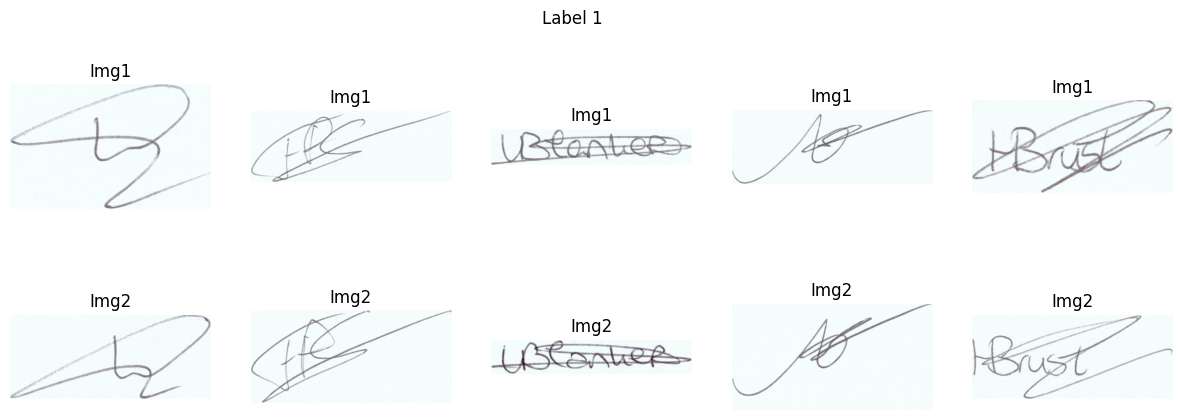

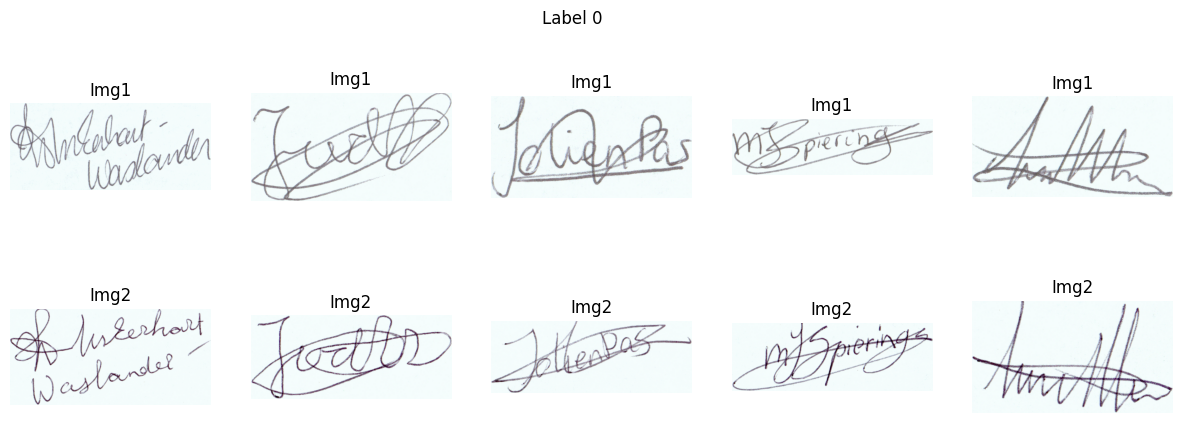

In [17]:
# Show some true and forg images 

def plot_images_with_labels(images, title):
    images = images.sample(5)
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 5))
    for i in range(5):
        img_path_1 = images.iloc[i]['Img1']
        img_1 = mpimg.imread(train_dir + img_path_1)
        axes[0, i].imshow(img_1)
        axes[0, i].set_title('Img1')
        axes[0, i].axis('off')

        img_path_2 = images.iloc[i]['Img2']
        img_2 = mpimg.imread(train_dir + img_path_2)
        axes[1, i].imshow(img_2)
        axes[1, i].set_title('Img2')
        axes[1, i].axis('off')

    fig.suptitle(title)
    plt.show()

label_1_images = df_train[df_train['label'] == 1]
label_0_images = df_train[df_train['label'] == 0]

plot_images_with_labels(label_1_images, "Label 1")
plot_images_with_labels(label_0_images, "Label 0")

In [11]:
# 

widths = []
heights = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        image_path = os.path.join(root, file)

        img = cv2.imread(image_path)

        height, width, _ = img.shape
        widths.append(width)
        heights.append(height)


med_w = int(np.median(widths)) // 2
med_h = int(np.median(heights)) // 2

print("med_w:", med_w)
print("med_h:", med_h)

med_w: 324
med_h: 128


In [12]:
class DataLoader:
    def __init__(self, df, batch_size, dir, shuffle_ = True):
        self.df = df
        self.batch_size = batch_size
        self.dir = dir
        self.shuffle_ = shuffle_
    
    def shuffle(self):
        return self.df.sample(frac = 1)
    
    def datagen(self):
        num_samples = len(self.df)
        while True:
            if self.shuffle_:
                self.df = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [cv2.imread(f"{self.dir}/{img}", cv2.IMREAD_GRAYSCALE) for img in self.df['Img1'].iloc[batch : batch + self.batch_size]]
                image2_batch_samples = [cv2.imread(f"{self.dir}/{img}", cv2.IMREAD_GRAYSCALE) for img in self.df['Img2'].iloc[batch : batch + self.batch_size]]
                label_batch_samples = self.df['label'].iloc[batch : batch + self.batch_size]
                Image1, Image2, Label = [], [], []

                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                    image1_data = cv2.resize(image1, (med_w, med_h))
                    image2_data = cv2.resize(image2, (med_w, med_h))
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)
                
                Image1 = np.asarray(Image1).astype(np.float32) / 255.0
                Image2 = np.asarray(Image2).astype(np.float32) / 255.0
                Label = np.asarray(to_categorical(Label)).astype(np.float32)

                yield [Image1, Image2], Label


In [13]:
train_set, val_set = train_test_split(df_train, test_size = 0.2)

In [14]:
train_gen = DataLoader(train_set, 32, train_dir)
val_gen = DataLoader(val_set, 32, train_dir)

In [22]:
train_batch = next(train_gen.datagen())
print("Train batch images shape:", train_batch[0][0].shape, train_batch[0][1].shape)
print("Train batch labels shape:", train_batch[1].shape)

Train batch images shape: (32, 128, 324) (32, 128, 324)
Train batch labels shape: (32, 2)


In [23]:
input_shape = (med_h, med_w, 1)

inp1 = Input(shape = input_shape)
inp2 = Input(shape = input_shape)

input_ = Input(shape = input_shape)
body = BatchNormalization()(input_)

body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Conv2D(64, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

feature_model = Model(inputs = input_, outputs = body)

model_img1 = feature_model(inp1)
model_img2 = feature_model(inp2)

body = Subtract()([model_img1, model_img2])
body = Conv2D(64, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2, 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Flatten()(body)
body = Dense(512, activation = 'elu')(body)
body = Dense(2, activation = 'softmax')(body)

optimizer = Nadam(learning_rate = 0.001)
model = Model(inputs = [inp1, inp2], outputs = body)
model.compile(optimizer = optimizer, 
              loss ='binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 32, 81, 64)   19204       ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [16]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, min_lr = 0.00001, verbose = True)
early_stopper =  EarlyStopping(monitor = 'val_loss', patience = 5, verbose = True)
tensorboard = TensorBoard(log_dir = './TensorBoardRuns/Model1/')

In [25]:
model.fit_generator(
    train_gen.datagen(),
    verbose = True,
    steps_per_epoch = 64,
    epochs = 50,
    validation_data = val_gen.datagen(),
    validation_steps = 16,
    callbacks = [reduce_lr, early_stopper, tensorboard]
)

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\1847410338.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
64/64 [==============================] - 86s 1s/step - loss: 0.7032 - accuracy: 0.8188 - val_loss: 1.6278 - val_accuracy: 0.5137 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 24s 383ms/step - loss: 0.2530 - accuracy: 0.9067 - val_loss: 2.8124 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 16s 245ms/step - loss: 0.1842 - accuracy: 0.9233 - val_loss: 2.5359 - val_accuracy: 0.5488 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 16s 250ms/step - loss: 0.1267 - accuracy: 0.9551 - val_loss: 0.3899 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 16s 243ms/step - loss: 0.0985 - accuracy: 0.9614 - val_loss: 0.6869 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 14s 222ms/step - loss: 0.0659 - accuracy: 0.9785 - val_loss: 0.2933 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 158s 3s/step - 

In [71]:
def evaluate_model(model, test_gen : DataLoader, df_test : pd.DataFrame):
    y_pred = model.predict_generator(test_gen.datagen(), steps = len(df_test) // 32)
    y_true = df_test['label'].values[: (len(df_test) // 32) * 32]
    
    print("Classification Report:")
    print(classification_report(y_true, np.argmax(y_pred, axis = 1)))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis = 1))
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', 
                xticklabels = ['Fake signature', 'True signature'], 
                yticklabels = ['Fake signature', 'True signature'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred[:, 1])
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    print("ROC-AUC Score:", roc_auc_score(y_true, y_pred[:, 1]))
    print("Kappa:", cohen_kappa_score(y_true, np.argmax(y_pred, axis = 1)))
    print("MCC:", matthews_corrcoef(y_true, np.argmax(y_pred, axis = 1)))

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\1483364907.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen.datagen(), steps = len(df_test) // 32)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2976
           1       0.96      1.00      0.98      2752

    accuracy                           0.98      5728
   macro avg       0.98      0.98      0.98      5728
weighted avg       0.98      0.98      0.98      5728

Confusion Matrix:


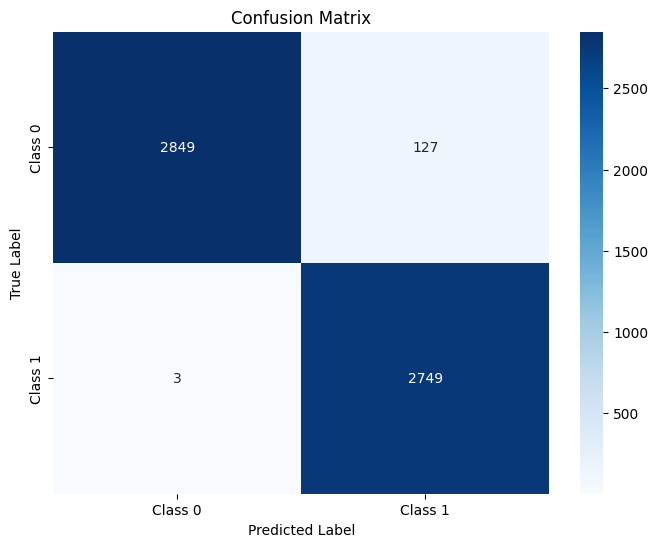

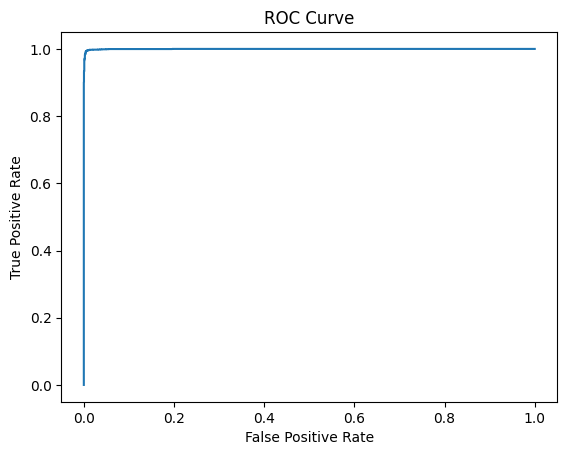

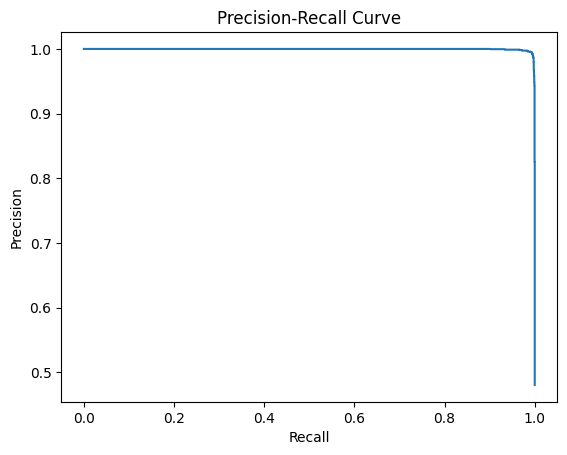

ROC-AUC Score: 0.9996913290822705
Kappa: 0.954616374770839
MCC: 0.9555120794098125


In [39]:
test_gen = DataLoader(df_test, batch_size = 32, dir = test_dir, shuffle_ = False)
evaluate_model(model, test_gen, df_test)

![](accyracy_model1.png)

![](./loss_model1.png)

In [43]:
inp1 = Input(shape = input_shape)
inp2 = Input(shape = input_shape)

input_ = Input(shape = input_shape)
body = BatchNormalization()(input_)

body = Conv2D(16, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

feature_model = Model(inputs = input_, outputs = body)

model_img1 = feature_model(inp1)
model_img2 = feature_model(inp2)

body = Subtract()([model_img1, model_img2])
body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2, 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Flatten()(body)
body = Dense(512, activation = 'elu')(body)
body = Dense(2, activation = 'softmax')(body)

optimizer = Nadam(learning_rate = 0.001)
model = Model(inputs = [inp1, inp2], outputs = body)
model.compile(optimizer = optimizer, 
              loss ='binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir = './TensorBoardRuns/Model2/')

model.fit_generator(
    train_gen.datagen(),
    verbose = True,
    steps_per_epoch = 64,
    epochs = 50,
    validation_data = val_gen.datagen(),
    validation_steps = 16,
    callbacks = [reduce_lr, early_stopper, tensorboard]
)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_14 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_8 (Functional)           (None, 32, 81, 32)   4996        ['input_13[0][0]',               
                                                                  'input_14[0][0]']         

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\658536361.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
64/64 [==============================] - 21s 256ms/step - loss: 0.7353 - accuracy: 0.7529 - val_loss: 2.0763 - val_accuracy: 0.5430 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 17s 266ms/step - loss: 0.2732 - accuracy: 0.8892 - val_loss: 2.9869 - val_accuracy: 0.5352 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 15s 236ms/step - loss: 0.2317 - accuracy: 0.9121 - val_loss: 1.5186 - val_accuracy: 0.5586 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 14s 222ms/step - loss: 0.1659 - accuracy: 0.9351 - val_loss: 2.1757 - val_accuracy: 0.5996 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 14s 220ms/step - loss: 0.1465 - accuracy: 0.9434 - val_loss: 0.6276 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 14s 222ms/step - loss: 0.1204 - accuracy: 0.9541 - val_loss: 0.4197 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 14s 220ms/st

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\1483364907.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen.datagen(), steps = len(df_test) // 32)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.55      0.71      2976
           1       0.67      1.00      0.81      2752

    accuracy                           0.77      5728
   macro avg       0.84      0.78      0.76      5728
weighted avg       0.84      0.77      0.76      5728

Confusion Matrix:


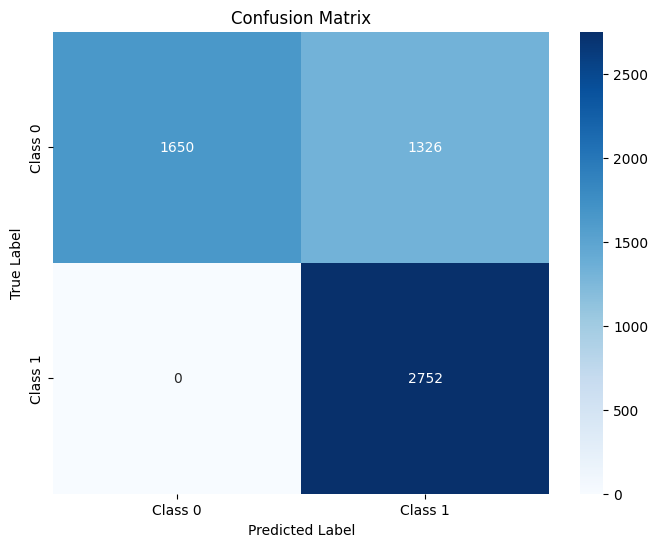

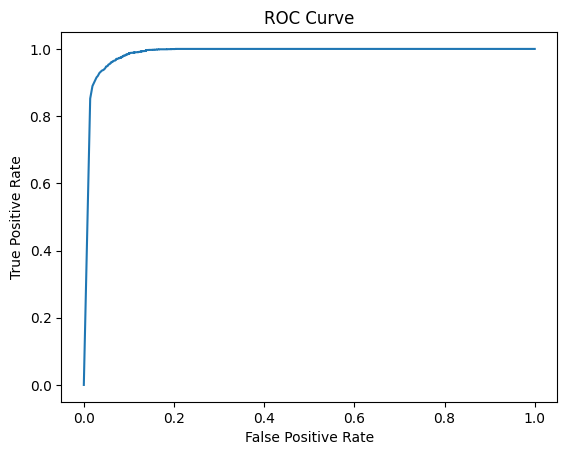

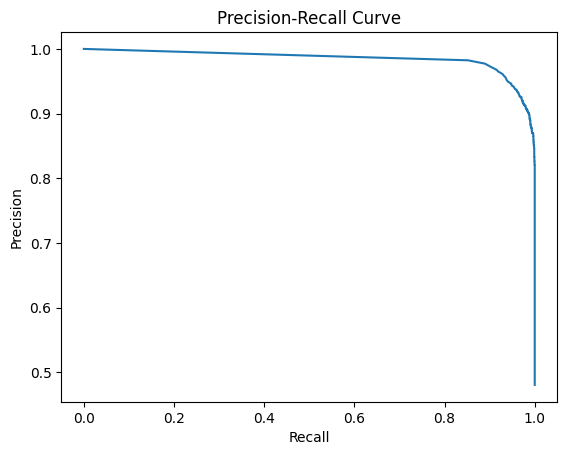

ROC-AUC Score: 0.9868977864583333
Kappa: 0.5445607248529225
MCC: 0.6116825803556691


In [44]:
evaluate_model(model, test_gen, df_test)

![](./accyracy_model2.png)

![](./loss_model2.png)

In [48]:
inp1 = Input(shape = input_shape)
inp2 = Input(shape = input_shape)

input_ = Input(shape = input_shape)
body = BatchNormalization()(input_)

body = Conv2D(16, (5, 5), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

feature_model = Model(inputs = input_, outputs = body)

model_img1 = feature_model(inp1)
model_img2 = feature_model(inp2)

body = Subtract()([model_img1, model_img2])
body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2, 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Flatten()(body)
body = Dense(512, activation = 'elu')(body)
body = Dense(2, activation = 'softmax')(body)

optimizer = Nadam(learning_rate = 0.001)
model = Model(inputs = [inp1, inp2], outputs = body)
model.compile(optimizer = optimizer, 
              loss ='binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir = './TensorBoardRuns/Model3/')

model.fit_generator(
    train_gen.datagen(),
    verbose = True,
    steps_per_epoch = 64,
    epochs = 50,
    validation_data = val_gen.datagen(),
    validation_steps = 16,
    callbacks = [reduce_lr, early_stopper, tensorboard]
)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_26 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_16 (Functional)          (None, 32, 81, 32)   5252        ['input_25[0][0]',               
                                                                  'input_26[0][0]']        

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\521348892.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
64/64 [==============================] - 59s 750ms/step - loss: 0.6858 - accuracy: 0.7954 - val_loss: 2.8364 - val_accuracy: 0.5898 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 18s 277ms/step - loss: 0.2783 - accuracy: 0.8828 - val_loss: 2.1432 - val_accuracy: 0.5176 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 14s 225ms/step - loss: 0.1883 - accuracy: 0.9233 - val_loss: 0.9651 - val_accuracy: 0.6816 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 14s 224ms/step - loss: 0.1533 - accuracy: 0.9404 - val_loss: 1.0322 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 14s 223ms/step - loss: 0.1062 - accuracy: 0.9556 - val_loss: 0.3975 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 14s 223ms/step - loss: 0.0981 - accuracy: 0.9648 - val_loss: 0.4909 - val_accuracy: 0.8418 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 14s 224ms/st

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\1483364907.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen.datagen(), steps = len(df_test) // 32)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.83      2976
           1       0.76      1.00      0.86      2752

    accuracy                           0.85      5728
   macro avg       0.88      0.85      0.84      5728
weighted avg       0.88      0.85      0.84      5728

Confusion Matrix:


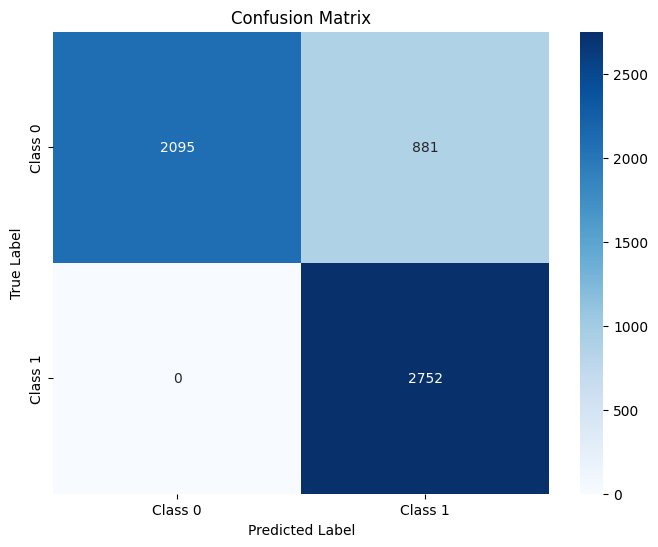

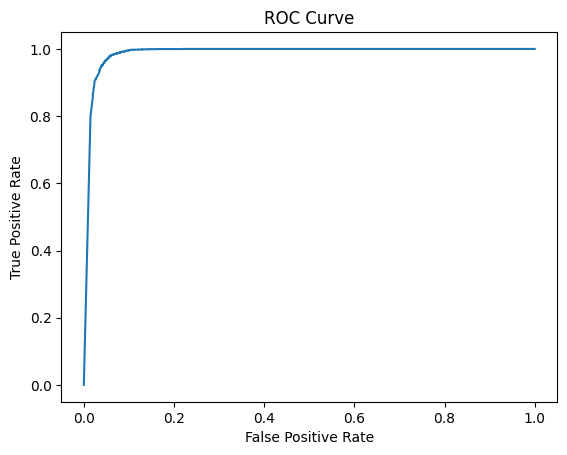

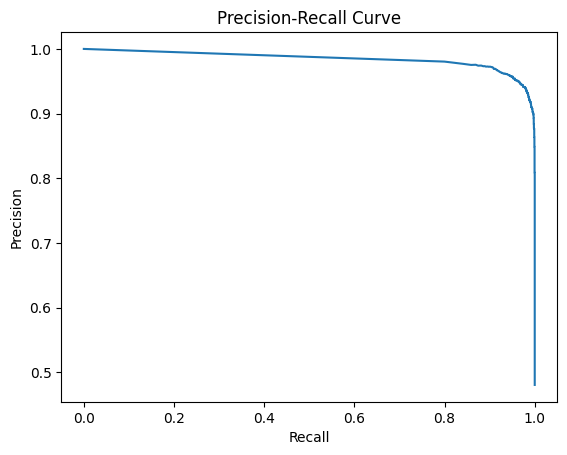

ROC-AUC Score: 0.9873712324565517
Kappa: 0.695584695360774
MCC: 0.730242434161336


In [49]:
evaluate_model(model, test_gen, df_test)

![](./accyracy_model3.png)

![](./loss_model3.png)

In [50]:
inp1 = Input(shape = input_shape)
inp2 = Input(shape = input_shape)

input_ = Input(shape = input_shape)
body = BatchNormalization()(input_)

body = Conv2D(16, (5, 5), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Conv2D(64, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

feature_model = Model(inputs = input_, outputs = body)

model_img1 = feature_model(inp1)
model_img2 = feature_model(inp2)

body = Subtract()([model_img1, model_img2])
body = Conv2D(64, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2, 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Flatten()(body)
body = Dense(512, activation = 'elu')(body)
body = Dense(2, activation = 'softmax')(body)

optimizer = Nadam(learning_rate = 0.001)
model = Model(inputs = [inp1, inp2], outputs = body)
model.compile(optimizer = optimizer, 
              loss ='binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir = './TensorBoardRuns/Model4/')

model.fit_generator(
    train_gen.datagen(),
    verbose = True,
    steps_per_epoch = 64,
    epochs = 50,
    validation_data = val_gen.datagen(),
    validation_steps = 16,
    callbacks = [reduce_lr, early_stopper, tensorboard]
)

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_29 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_18 (Functional)          (None, 16, 40, 64)   24004       ['input_28[0][0]',               
                                                                  'input_29[0][0]']        

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\384023744.py:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
64/64 [==============================] - 43s 605ms/step - loss: 0.7254 - accuracy: 0.7837 - val_loss: 1.3816 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 18s 283ms/step - loss: 0.3084 - accuracy: 0.8804 - val_loss: 1.6366 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 15s 229ms/step - loss: 0.2565 - accuracy: 0.8901 - val_loss: 1.0869 - val_accuracy: 0.5918 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 15s 228ms/step - loss: 0.2109 - accuracy: 0.9106 - val_loss: 1.5202 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 14s 223ms/step - loss: 0.1707 - accuracy: 0.9287 - val_loss: 1.1687 - val_accuracy: 0.6387 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 15s 228ms/step - loss: 0.1632 - accuracy: 0.9351 - val_loss: 0.9287 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 14s 225ms/st

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\1483364907.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen.datagen(), steps = len(df_test) // 32)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.72      2976
           1       0.68      1.00      0.81      2752

    accuracy                           0.77      5728
   macro avg       0.84      0.78      0.76      5728
weighted avg       0.85      0.77      0.76      5728

Confusion Matrix:


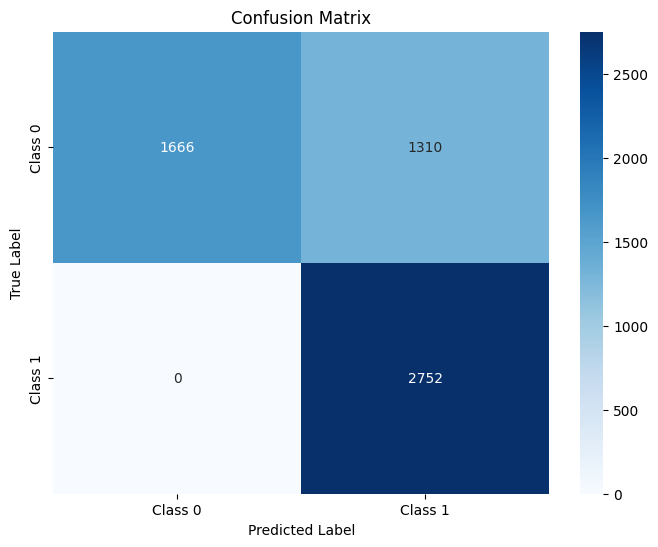

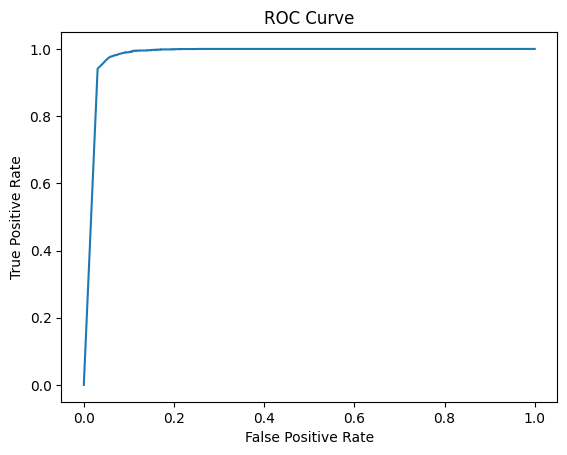

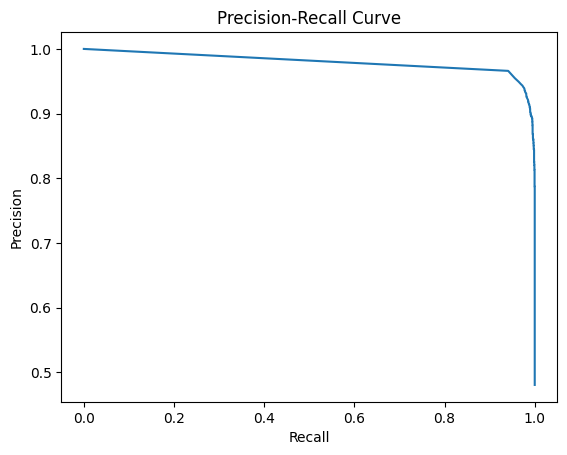

ROC-AUC Score: 0.9816607594281382
Kappa: 0.5499595042242277
MCC: 0.6158504886389854


In [51]:
evaluate_model(model, test_gen, df_test)

![](./accuracy_model4.png)

![](./loss_model4.png)

In [54]:
inp1 = Input(shape = input_shape)
inp2 = Input(shape = input_shape)

input_ = Input(shape = input_shape)
body = BatchNormalization()(input_)

body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Conv2D(64, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Conv2D(64, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

feature_model = Model(inputs = input_, outputs = body)

model_img1 = feature_model(inp1)
model_img2 = feature_model(inp2)

body = Subtract()([model_img1, model_img2])
body = Conv2D(64, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2, 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Flatten()(body)
body = Dense(512, activation = 'elu')(body)
body = Dense(2, activation = 'softmax')(body)

optimizer = Nadam(learning_rate = 0.001)
model = Model(inputs = [inp1, inp2], outputs = body)
model.compile(optimizer = optimizer, 
              loss ='binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir = './TensorBoardRuns/Model5/')

model.fit_generator(
    train_gen.datagen(),
    verbose = True,
    steps_per_epoch = 64,
    epochs = 50,
    validation_data = val_gen.datagen(),
    validation_steps = 16,
    callbacks = [reduce_lr, early_stopper, tensorboard]
)

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_35 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_22 (Functional)          (None, 16, 40, 64)   56388       ['input_34[0][0]',               
                                                                  'input_35[0][0]']        

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\274754790.py:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
64/64 [==============================] - 45s 517ms/step - loss: 0.7614 - accuracy: 0.7817 - val_loss: 2.7210 - val_accuracy: 0.5195 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 21s 331ms/step - loss: 0.3434 - accuracy: 0.8633 - val_loss: 1.9770 - val_accuracy: 0.5137 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 15s 234ms/step - loss: 0.2660 - accuracy: 0.8940 - val_loss: 1.6319 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 15s 229ms/step - loss: 0.2298 - accuracy: 0.9087 - val_loss: 0.6518 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 14s 225ms/step - loss: 0.1803 - accuracy: 0.9233 - val_loss: 0.3512 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 14s 223ms/step - loss: 0.1603 - accuracy: 0.9380 - val_loss: 0.6898 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 15s 238ms/st

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\1483364907.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen.datagen(), steps = len(df_test) // 32)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69      2976
           1       0.66      1.00      0.80      2752

    accuracy                           0.75      5728
   macro avg       0.83      0.76      0.74      5728
weighted avg       0.84      0.75      0.74      5728

Confusion Matrix:


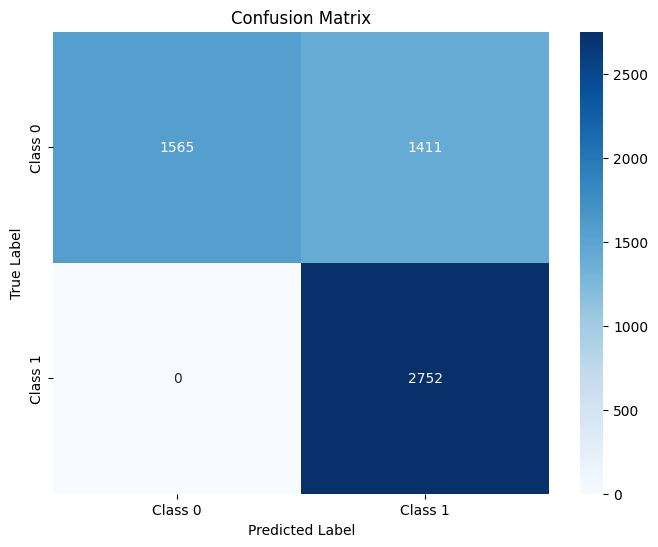

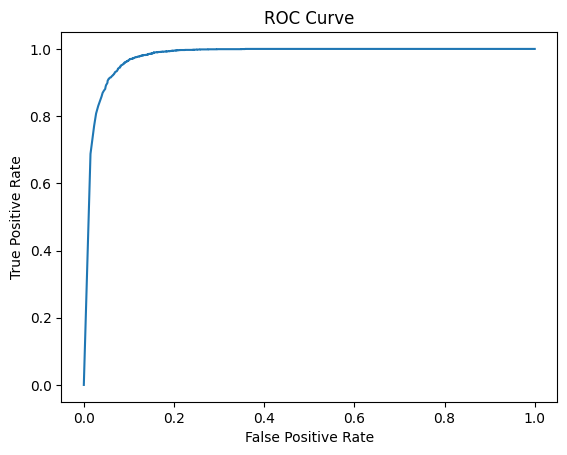

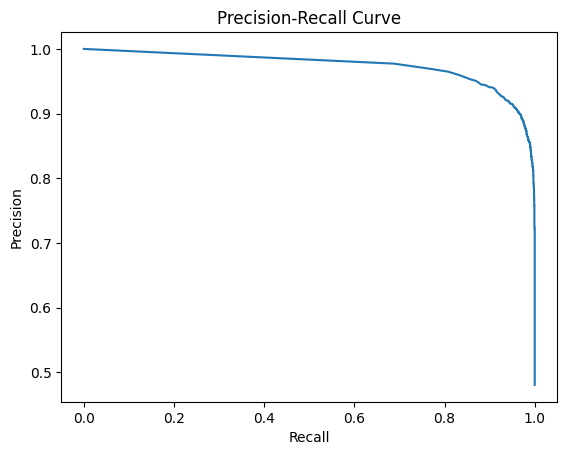

ROC-AUC Score: 0.9789209387307765
Kappa: 0.5159185738736443
MCC: 0.5896057589737042


In [55]:
evaluate_model(model, test_gen, df_test)

![](./accuracy_model5.png)

![](./loss_model5.png)

In [ ]:
folder_path = os.path.join("./sign_data", "train")

for subfolder_name in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder_name)

    pipeline = Augmentor.Pipeline(subfolder_path, output_directory = "./")
    pipeline.rotate(probability = 0.9, max_left_rotation = 5, max_right_rotation = 5)
    pipeline.zoom_random(probability = 0.9, percentage_area = 0.95)
    pipeline.sample(12)
        

In [18]:
data = []

folder_path = os.path.join("./sign_data", "train")

for root, dirs, files in os.walk(folder_path):
    for subfolder_name in dirs:
        if subfolder_name.endswith("_forg"):
            continue

        subfolder_path = os.path.join(root, subfolder_name)
        forg_folder_path = os.path.join(root, subfolder_name + "_forg")

        images = [f for f in os.listdir(subfolder_path) if f.endswith('.PNG') or f.endswith('.png')]
        forg_images = [f for f in os.listdir(forg_folder_path) if f.endswith('.png') or f.endswith('.PNG')]

        for img1_name in images:
            for img2_name in images:
                if img1_name != img2_name:
                    data.append({'Img1': os.path.join(subfolder_name, img1_name),
                                    'Img2': os.path.join(subfolder_name, img2_name),
                                    'label': 1})

        for img1_name in images:
            for img2_name in forg_images:
                data.append({'Img1': os.path.join(subfolder_name, img1_name),
                                'Img2': os.path.join(subfolder_name + "_forg", img2_name),
                                'label': 0})


df = pd.DataFrame(data)
df.shape

(81946, 3)

In [19]:
train_set, val_set = train_test_split(df, test_size = 0.2)
train_gen = DataLoader(train_set, 32, train_dir)
val_gen = DataLoader(val_set, 32, train_dir)

In [106]:
inp1 = Input(shape = input_shape)
inp2 = Input(shape = input_shape)

input_ = Input(shape = input_shape)
body = BatchNormalization()(input_)

body = Conv2D(16, (5, 5), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

feature_model = Model(inputs = input_, outputs = body)

model_img1 = feature_model(inp1)
model_img2 = feature_model(inp2)

body = Subtract()([model_img1, model_img2])
body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2, 2))(body)
body = Dropout(0.5)(body)
body = BatchNormalization()(body)

body = Flatten()(body)
body = Dense(512, activation = 'elu')(body)
body = Dense(2, activation = 'softmax')(body)

optimizer = Nadam(learning_rate = 0.001)
model = Model(inputs = [inp1, inp2], outputs = body)
model.compile(optimizer = optimizer, 
              loss ='binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir = './TensorBoardRuns/Model6/')

model.fit_generator(
    train_gen.datagen(),
    verbose = True,
    steps_per_epoch = 64,
    epochs = 50,
    validation_data = val_gen.datagen(),
    validation_steps = 16,
    callbacks = [reduce_lr, early_stopper, tensorboard]
)

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_38 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_24 (Functional)          (None, 32, 81, 32)   5252        ['input_37[0][0]',               
                                                                  'input_38[0][0]']        

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\1430765399.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
64/64 [==============================] - 179s 3s/step - loss: 0.7422 - accuracy: 0.7695 - val_loss: 1.8340 - val_accuracy: 0.5039 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 32s 498ms/step - loss: 0.3266 - accuracy: 0.8677 - val_loss: 1.8772 - val_accuracy: 0.5332 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 24s 383ms/step - loss: 0.2756 - accuracy: 0.8892 - val_loss: 0.4648 - val_accuracy: 0.7930 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 20s 312ms/step - loss: 0.2426 - accuracy: 0.9019 - val_loss: 0.6763 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 18s 289ms/step - loss: 0.2075 - accuracy: 0.9238 - val_loss: 0.3566 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 19s 292ms/step - loss: 0.1871 - accuracy: 0.9399 - val_loss: 0.4543 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 18s 278ms/step

C:\Users\misha\AppData\Local\Temp\ipykernel_4164\1483364907.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen.datagen(), steps = len(df_test) // 32)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      2976
           1       0.88      1.00      0.94      2752

    accuracy                           0.93      5728
   macro avg       0.94      0.94      0.93      5728
weighted avg       0.94      0.93      0.93      5728

Confusion Matrix:


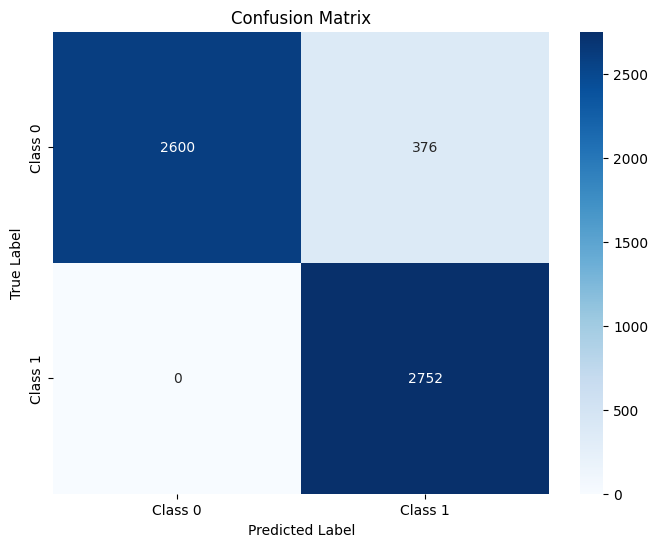

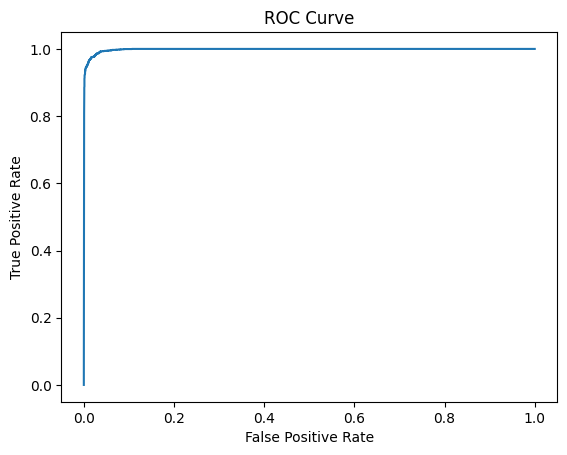

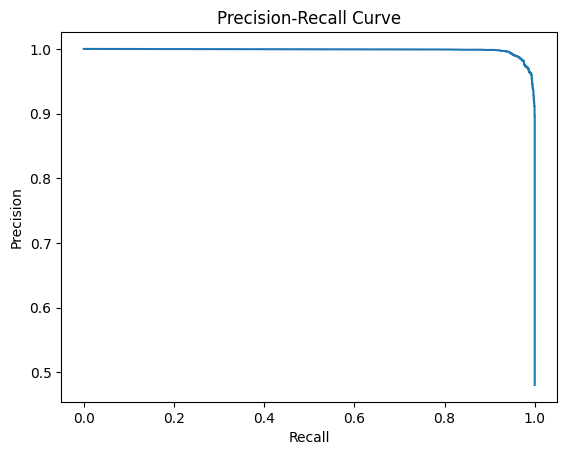

ROC-AUC Score: 0.9982396722227431
Kappa: 0.869186634117519
MCC: 0.8767202810320379


In [107]:
evaluate_model(model, test_gen, df_test)

![](./acuracy_model6.png)

![](./loss_model6.png)

In [140]:
def wavlet_appy(wavlet):
    image = cv2.imread('./sign_data/train/001/001_01.PNG', cv2.IMREAD_GRAYSCALE)
    image = cv2.medianBlur(image, 5)

    coeffs = pywt.dwt2(image, wavlet)
    LL, (LH, HL, HH) = coeffs

    LL = np.uint8(LL)
    LH = np.uint8(LH)
    HL = np.uint8(HL)
    HH = np.uint8(HH)

    _, LH_thresh = cv2.threshold(LH, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    _, HL_thresh = cv2.threshold(HL, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    _, HH_thresh = cv2.threshold(HH, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    edges = cv2.bitwise_or(cv2.bitwise_or(LH_thresh, HL_thresh), HH_thresh)
    edges = cv2.medianBlur(edges, 5)
    edges = 255 - edges

    plt.figure(figsize = (10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap = 'gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap = 'gray')
    plt.title('Edges')
    plt.axis('off')

    plt.show()

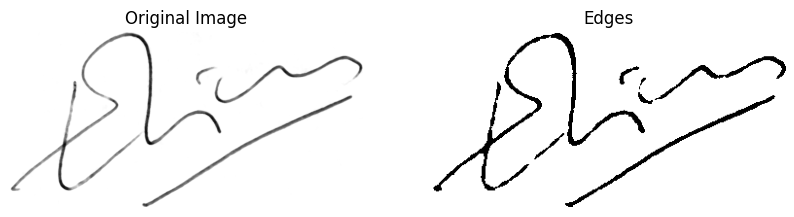

In [141]:
wavlet_appy('haar')

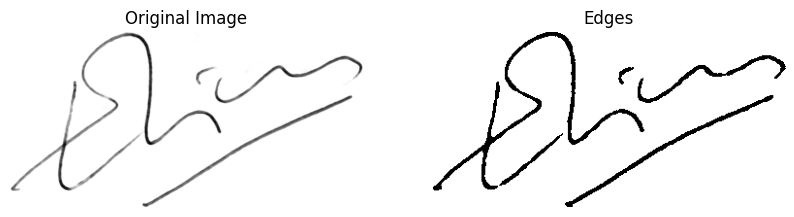

In [163]:
wavlet_appy('db2')

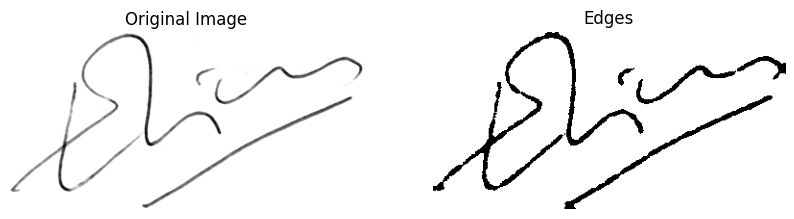

In [149]:
wavlet_appy('coif2')

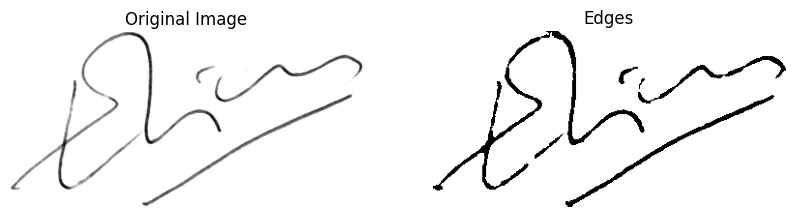

In [167]:
wavlet_appy('bior1.3')

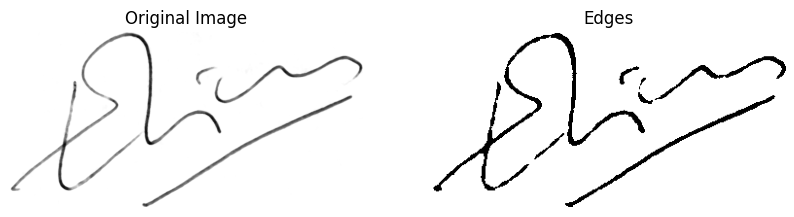

In [169]:
wavlet_appy('rbio1.1')

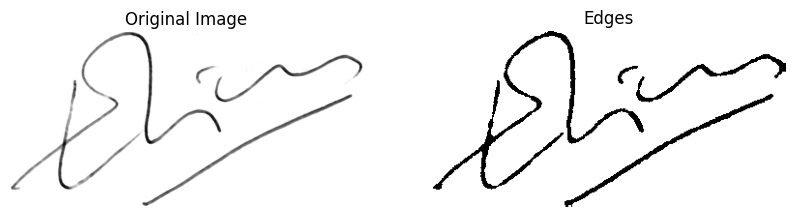

In [171]:
wavlet_appy('rbio1.3')

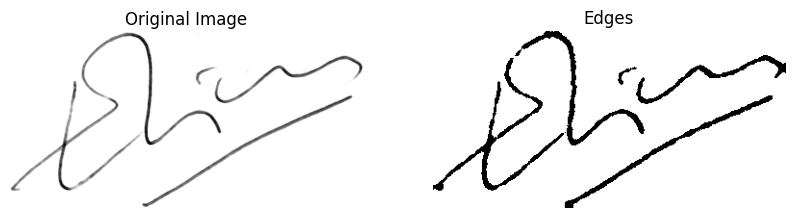

In [173]:
wavlet_appy('rbio1.5')

In [81]:
class WavletDataLoader:
    def __init__(self, df, batch_size, dir, shuffle_ = True):
        self.df = df
        self.batch_size = batch_size
        self.dir = dir
        self.shuffle_ = shuffle_
    
    def shuffle(self):
        return self.df.sample(frac = 1)

    def apply_wevlet(self, img):
        img = cv2.medianBlur(img, 3)
        coeffs = pywt.dwt2(img, "rbio1.3")
        LL, (LH, HL, HH) = coeffs

        LL = np.uint8(LL)
        LH = np.uint8(LH)
        HL = np.uint8(HL)
        HH = np.uint8(HH)

        _, LH_thresh = cv2.threshold(LH, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        _, HL_thresh = cv2.threshold(HL, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        _, HH_thresh = cv2.threshold(HH, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        img = cv2.bitwise_or(cv2.bitwise_or(LH_thresh, HL_thresh), HH_thresh)
        img = cv2.medianBlur(img, 3)
        img = 255 - img
        return img

    
    def datagen(self):
        num_samples = len(self.df)
        while True:
            if self.shuffle_:
                self.df = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [cv2.imread(f"{self.dir}/{img}", cv2.IMREAD_GRAYSCALE) for img in self.df['Img1'].iloc[batch : batch + self.batch_size]]
                image2_batch_samples = [cv2.imread(f"{self.dir}/{img}", cv2.IMREAD_GRAYSCALE) for img in self.df['Img2'].iloc[batch : batch + self.batch_size]]
                label_batch_samples = self.df['label'].iloc[batch : batch + self.batch_size]

                Image1, Image2, Label = [], [], []

                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                    image1 = self.apply_wevlet(image1)
                    image2 = self.apply_wevlet(image2)

                    image1_data = cv2.resize(image1, (med_w, med_h))
                    image2_data = cv2.resize(image2, (med_w, med_h))
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)
                
                Image1 = np.asarray(Image1).astype(np.float32) / 255.0
                Image2 = np.asarray(Image2).astype(np.float32) / 255.0
                Label = np.asarray(to_categorical(Label)).astype(np.float32)

                yield [Image1, Image2], Label


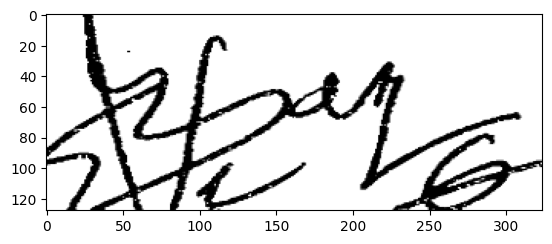

In [82]:
train_gen = WavletDataLoader(train_set, 32, train_dir)
val_gen = WavletDataLoader(val_set, 32, train_dir)

train_batch = next(train_gen.datagen())
plt.imshow(train_batch[0][0][0], cmap = 'gray')

In [83]:
inp1 = Input(shape = input_shape)
inp2 = Input(shape = input_shape)

input_ = Input(shape = input_shape)

body = Conv2D(16, (5, 5), padding = 'same', activation = 'elu')(input_)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)

body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2 , 2))(body)
body = Dropout(0.5)(body)
feature_model = Model(inputs = input_, outputs = body)

model_img1 = feature_model(inp1)
model_img2 = feature_model(inp2)

body = Subtract()([model_img1, model_img2])
body = Conv2D(32, (3, 3), padding = 'same', activation = 'elu')(body)
body = MaxPooling2D((2, 2))(body)
body = Dropout(0.5)(body)

body = Flatten()(body)
body = Dense(512, activation = 'elu')(body)
body = Dense(2, activation = 'softmax')(body)

optimizer = Nadam(learning_rate = 0.001)
model = Model(inputs = [inp1, inp2], outputs = body)
model.compile(optimizer = optimizer, 
              loss ='binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir = './TensorBoardRuns/Model7/')

model.fit_generator(
    train_gen.datagen(),
    verbose = True,
    steps_per_epoch = 64,
    epochs = 50,
    validation_data = val_gen.datagen(),
    validation_steps = 16,
    callbacks = [reduce_lr, early_stopper, tensorboard]
)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_17 (InputLayer)          [(None, 128, 324, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_10 (Functional)          (None, 32, 81, 32)   5252        ['input_16[0][0]',               
                                                                  'input_17[0][0]']        

C:\Users\misha\AppData\Local\Temp\ipykernel_10404\2265347381.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
64/64 [==============================] - 197s 3s/step - loss: 1.0872 - accuracy: 0.5815 - val_loss: 0.9006 - val_accuracy: 0.5410 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 56s 884ms/step - loss: 0.6456 - accuracy: 0.6465 - val_loss: 0.6266 - val_accuracy: 0.6309 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 44s 693ms/step - loss: 0.5600 - accuracy: 0.7246 - val_loss: 0.6274 - val_accuracy: 0.6641 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 39s 621ms/step - loss: 0.4914 - accuracy: 0.7739 - val_loss: 0.9588 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.7881
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
64/64 [==============================] - 36s 571ms/step - loss: 0.4533 - accuracy: 0.7881 - val_loss: 0.6631 - val_accuracy: 0.6895 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 37s 578ms/

C:\Users\misha\AppData\Local\Temp\ipykernel_10404\1063600243.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen.datagen(), steps = len(df_test) // 32)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77      2976
           1       0.71      0.96      0.82      2752

    accuracy                           0.80      5728
   macro avg       0.83      0.80      0.79      5728
weighted avg       0.83      0.80      0.79      5728

Confusion Matrix:


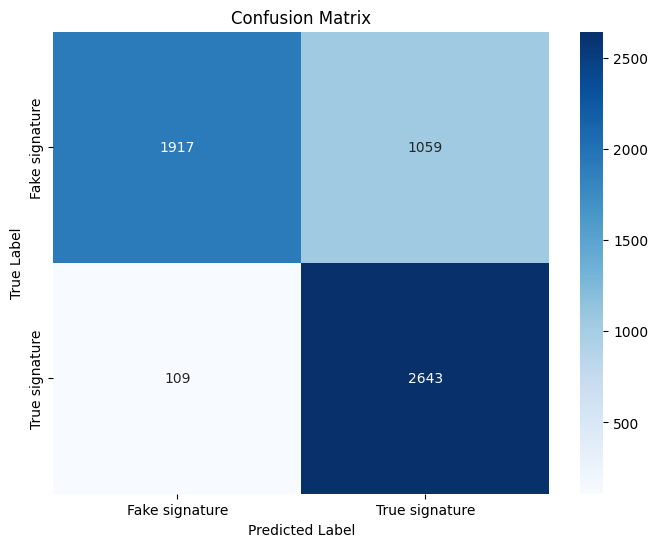

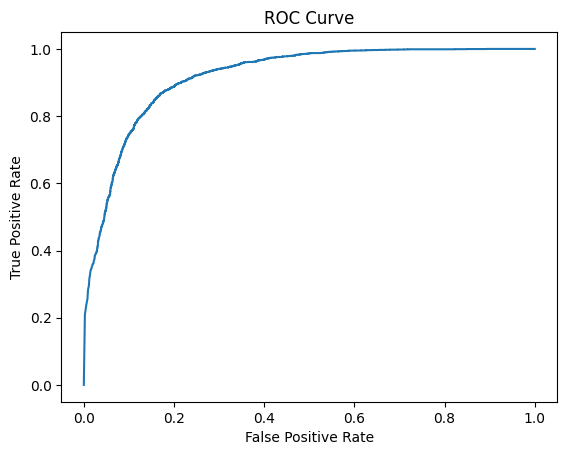

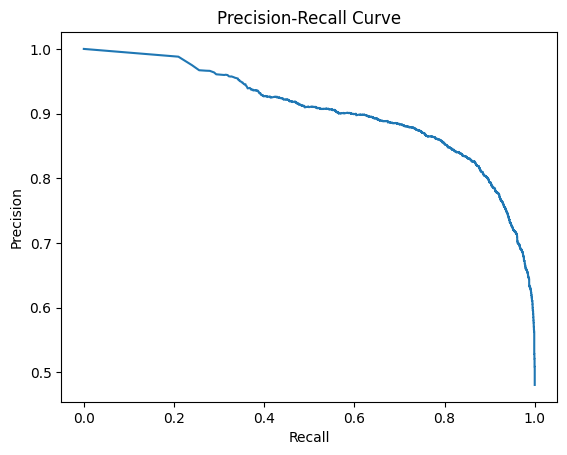

ROC-AUC Score: 0.9181924997851026
Kappa: 0.5967924215365983
MCC: 0.631730527015101


In [72]:
test_gen = WavletDataLoader(df_test, batch_size = 32, dir = test_dir, shuffle_ = False)
evaluate_model(model, test_gen, df_test)